In [21]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

import torchbnn as bnn
import matplotlib.pyplot as plt

In [130]:
dataset = pd.read_csv('smart_grid_stability_augmented.csv')
dataset.replace({'stabf': {'unstable':0, 'stable':1}}, inplace=True)
dataset.drop(columns=['stab'])

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,1
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,1
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0


In [175]:
from sklearn.preprocessing import StandardScaler

In [176]:
x = dataset.iloc[:, :12]
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(x)
#x = (x-x.min())/(x.max()-x.min())
y = dataset['stabf']
x = x.to_numpy()
y = y.to_numpy()
X_test= x[len(x)-1000:len(x)]
t_test=y[len(x)-1000:len(x)]

X_val= x[len(x)-2000:len(x)-1000]
y_val=y[len(x)-2000:len(x)-1000]

In [177]:
x_train=torch.tensor(x[0:50000], dtype=torch.float)
y_train=torch.from_numpy(y[0:50000]).long()

x_test=torch.tensor(X_test, dtype=torch.float)
y_test=torch.from_numpy(t_test).long() 

x_val=torch.tensor(X_val, dtype=torch.float)
y_val=torch.from_numpy(y_val).long()

In [191]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=12, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=2),
)

In [192]:

ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.005)

In [193]:
kl_weight = 0.1

In [194]:
# for step in range(1000):
#     pre = model(x_train)
#     ce = ce_loss(pre, y_train)
#     kl = kl_loss(model)
#     cost = ce + kl_weight*kl
    
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
    
# _, predicted = torch.max(pre.data, 1)
# total = y_train.size(0)
# correct = (predicted == y_train).sum()
# print('- Accuracy: %f %%' % (100 * float(correct) / total))
# print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

# Train

In [198]:
epochs=3000
loss =torch.tensor([])
KL = torch.tensor([])
Cost = torch.tensor([])

loss_val =torch.tensor([])
KL_val = torch.tensor([])
Cost_val = torch.tensor([])

train_acc = torch.tensor([])
val_acc = torch.tensor([])


for step in range(epochs):
    pre = model(x_train)
    ce = ce_loss(pre, y_train)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    loss = torch.cat((loss,torch.tensor([ce.item()])),0)
    KL = torch.cat((KL,torch.tensor([kl.item()])),0)
    Cost = torch.cat((Cost,torch.tensor([cost.item()])),0)
    
    pre_val = model(x_val)
    ce_val = ce_loss(pre_val, y_val)
    kl_val = kl_loss(model)
    cost_val = ce_val + kl_weight*kl_val
    
    loss_val = torch.cat((loss_val,torch.tensor([ce_val.item()])),0)
    KL_val = torch.cat((KL_val,torch.tensor([kl_val.item()])),0)
    Cost_val = torch.cat((Cost_val,torch.tensor([cost_val.item()])),0)
    
    #accuracy check
    
    #train accuracy
    _, predicted = torch.max(pre.data, 1)
    total = y_train.size(0)
    correct = (predicted == y_train).sum()
    train_acc = torch.cat((train_acc,torch.tensor([100 * float(correct) / total])),0)
    
    #val accuracy
    _, predicted = torch.max(pre_val.data, 1)
    total = y_val.size(0)
    correct = (predicted == y_val).sum()
    val_acc = torch.cat((val_acc,torch.tensor([100 * float(correct) / total])),0)
    
    

In [199]:
epoc =torch.tensor( np.arange(1,epochs+1))

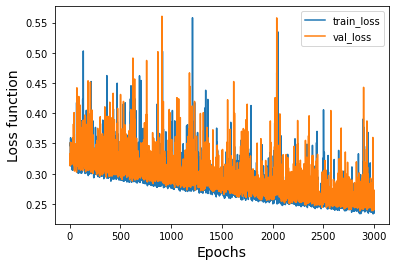

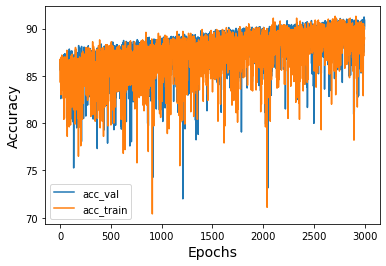

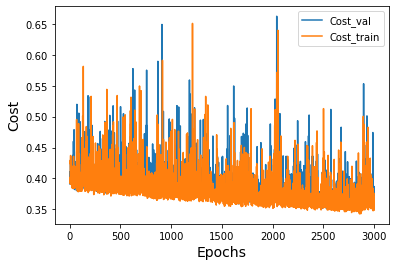

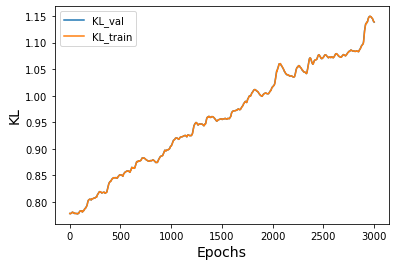

In [200]:

plt.plot(epoc,loss,label='train_loss')
plt.plot(epoc,loss_val,label='val_loss')
plt.xlabel('Epochs',size=14)
plt.ylabel('Loss function',size=14)
plt.legend()
plt.show()
plt.plot(epoc,train_acc,label='acc_val')
plt.plot(epoc,val_acc,label='acc_train')
plt.xlabel('Epochs',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend()
plt.show()

plt.plot(epoc,Cost_val,label='Cost_val')
plt.plot(epoc,Cost,label='Cost_train')
plt.xlabel('Epochs',size=14)
plt.ylabel('Cost',size=14)
plt.legend()
plt.show()

plt.plot(epoc,KL_val,label='KL_val')
plt.plot(epoc,KL,label='KL_train')
plt.xlabel('Epochs',size=14)
plt.ylabel('KL',size=14)
plt.legend()
plt.show()

# Test Model

In [201]:
pre_test = model(x_test)
_, predicted = torch.max(pre_test.data, 1)
total = y_test.size(0)
correct = (predicted == y_test).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 89.600000 %
- CE : 0.26, KL : 1.14


In [202]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

           1     0.8820    0.8351    0.8579       376
           0     0.9037    0.9327    0.9180       624

    accuracy                         0.8960      1000
   macro avg     0.8929    0.8839    0.8880      1000
weighted avg     0.8956    0.8960    0.8954      1000



[Text(0, 0.5, 'STABLE'), Text(0, 1.5, 'UNSTABLE')]

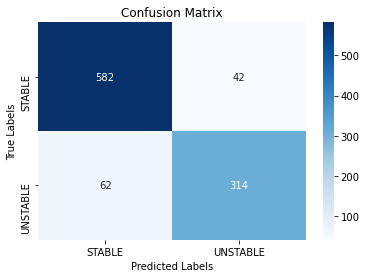

In [203]:
print('Classification Report:')

print(classification_report(y_test, predicted, labels=[1,0], digits=4))       
cm_det = confusion_matrix(y_test, predicted)
ax= plt.subplot()
sns.heatmap(cm_det, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
ax.yaxis.set_ticklabels(['STABLE', 'UNSTABLE'])